<a href="https://colab.research.google.com/github/Zedbog/Data_science_course/blob/main/NLP_detektor_intencji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Celem postawionego zadania jest detekcja intencji, czyli stworzenie modelu, który rozpozna, o co chodziło użytkownikowi przy formułowniu polecenia dla smartfonu, aby wykonał jakąś czynność np. uruchomił odtwarzacz muzyki, sprawdził pogodę lub zarezerwował miejsce w restauracji.

Do wytrenowania modelu posłużę się datasetem zawierającym polecenia użytkowników w postaci luźno rzuconych komend i labelów etykietujących czynności, które smartfon ma wykonać.

Na początek wczytajmy datasety - treningowy i walidacyjny.

In [129]:
from google.colab import drive

In [130]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
data_train = pd.read_csv('/content/drive/MyDrive/18_REKURENCYJNE_SIECI_NEURONOWE/train.csv')
data_validation = pd.read_csv('/content/drive/MyDrive/18_REKURENCYJNE_SIECI_NEURONOWE/validation.csv')

In [133]:
data_train.head()

,text,label
0,find a cinema nearest for films,SearchScreeningEvent
1,Give the current series two stars.,RateBook
2,find The Good Girl at a movie house\n,SearchScreeningEvent
3,Please make reservations for three at a kosher...,BookRestaurant
4,what is the forecast for here one second from now,GetWeather


In [134]:
data_validation.head()

,text,label
0,What movies are showing now at the closest cin...,SearchScreeningEvent
1,Open itunes and play Ben Burnley Ready To Die,PlayMusic
2,What is the rain forecast for one hour from no...,GetWeather
3,Add porter wagoner to the The Sleep Machine Wa...,AddToPlaylist
4,Check the timings for Snowbound at the closest...,SearchScreeningEvent


In [135]:
# Wyświetlenie setu czynności wykonywanych przez smartfon
set(data_train['label'])

{'AddToPlaylist',
 'BookRestaurant',
 'GetWeather',
 'PlayMusic',
 'RateBook',
 'SearchCreativeWork',
 'SearchScreeningEvent'}

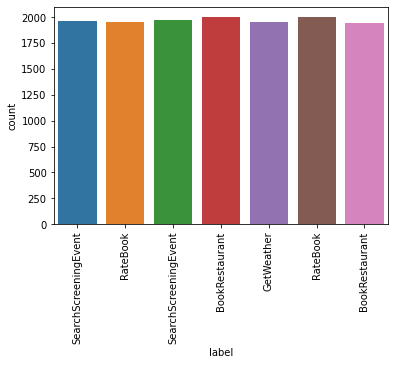

In [136]:
# Weryfikacja liczebności poszczególnych czynności w treningowym datasecie
barplot = sns.countplot(x='label', data=data_train)
barplot.set_xticklabels(data_train['label'], rotation=90)
# Pokaż wykres
plt.show()

Zbiór czynności jest zbalansowany, co pozwala przystąpić do preprocessingu danych bez konieczności balansowania zbioru.

# Preprocessing

In [137]:
# Weryfikacja kilku losowych komend użytkowników
data_train['text'].sample(10)

9460     Let me know the movie times for films in the a...
6747     Is it going to be freezing in Mahwah Missouri ...
4631           Get me a highly rated restaurant in Nigeria
9720     want to find the novel called Innocent Until C...
10668    Rate the current textbook with 2 points out of 6.
11134              is The Couch Trip at the nearest cinema
2488            play the song Memories Are My Only Witness
6351     show me the television show Operation Thunderbolt
11793             rate this current essay 4 out of 6 stars
3527                    Give the current essay 5 / 6 stars
Name: text, dtype: object

W celu "oczyszczenia" tekstu komend na podstawie kilku powyższych nasuwa się idea prepocessingu w postaci:

1. usunięcia znaków interpunkcyjnych,
2. usunięciu jendoliterowych tokenów np. 'a',
3. usunięciu stopwordsów,
4. lemantyzacji słów.


Przeprocesujmy cały tekst za pomocą jednej funkcji.

In [138]:
import re
import nltk
nltk.download('stopwords') # do usunięcia stopwordsów
nltk.download('wordnet') # do lemantyzacji
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [139]:
def utils_preprocess_text(text, flg_lemm=True, lst_stopwords=True):
  # 1.usunięcie znaków interpunkcyjnych
  text = re.sub(r'\W',' ', text)

  # 2.usunięcie jednoliterowych tokenów
  text = re.sub(r'\b[a-zA-Z]{1}\b',' ', text)

  # tokenizacja - konwersja z tekstu do listy słów
  lst_text = text.split()

  # 3.usunięcie stopwordsów
  if lst_stopwords is not None:
    lst_text = [word for word in lst_text if word not in lst_stopwords]

  # 4.lemantyzacja
  if flg_lemm == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
  
  # zwrócenie oczyszczonego tekstu
  text = ' '.join(lst_text)
  return text

In [140]:
# dodanie nowej kolumny do istniejącego data_train z oczyszczonymi komendami użytkowników
data_train['text_clean'] = data_train['text'].apply(lambda x:
                                                    utils_preprocess_text(
                                                        x,
                                                        flg_lemm=True,
                                                        lst_stopwords=set(stopwords.words('english'))
                                                    ))
data_train.sample(5)

,text,label,text_clean
1422,add apathy to my electro sur playlist,AddToPlaylist,add apathy electro sur playlist
9959,Add an artist to my Hype list,AddToPlaylist,Add artist Hype list
4484,book a spot at a pub that has trottole for the...,BookRestaurant,book spot pub trottole meal
5281,"Want a table at Monty’s Hotel, Secunderabad i...",BookRestaurant,Want table Monty Hotel Secunderabad state Vermont
7554,Play 2012 symphony music by Nardwuar The Human...,PlayMusic,Play 2012 symphony music Nardwuar The Human Se...


In [141]:
data_train['text_clean'].sample(10)

3162                          Play best music Klaus Badelt
7499                                        Find App Store
2261     For book The Flash Stop Motion give rating 5 p...
1727                                    Rate album 5 point
13338          Book restaurant marcella erma leanne rivera
4104          Please show movie playing Amco Entertainment
2121                               play music ballad sixty
7751                 Please use Itunes play something 1986
2091         What weather forecast 3 hour Christmas Island
6535                       Add feel passion kudai playlist
Name: text_clean, dtype: object

# Train_test_split

Kiedy dane są już przeprocesowane zajmijmy się ich podziałem w zbiorze data_train na treningowe (80%) i testowe(20%), które posłużą nam jako wstępne walidacyjne przed puszczeniem modelu na ostatecznych danych walidacyjnych.

In [142]:
from sklearn.model_selection import train_test_split

In [143]:
data_train['label'].values

array(['SearchScreeningEvent', 'RateBook', 'SearchScreeningEvent', ...,
       'RateBook', 'AddToPlaylist', 'SearchScreeningEvent'], dtype=object)

In [144]:
dtf_train, dtf_test = train_test_split(data_train, test_size=0.2, random_state=42)

# wydzielenie y_train i y_test
y_train = dtf_train['label'].values
y_test = dtf_test['label'].values

# wydzielenie X_test
X_test = dtf_test['text_clean'].values

W dalszej kolejności konieczna będzie zamiana tekstu na liczby, aby model mógł "zrozumieć" dane. 

# TfIdfVectorizer i podejście z klasycznym klasyfikatorem

W pierwszej kolejności analizie poddamy przekształcenie korpusu oczyszczonych danych za pomocą TfIdfVectorizera w celu wydobycia słownika najczęstych słów i stowrzenia macierzy cech - złożonej ze słów "kluczy" w tekstach komend poprzez przypisanie im stosownej wagi. Słowa będące najistotniejsze będą miały najwyższe wagi.

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [146]:
# stworzenie TfIdfVectorizera biorącego max 10000 najczęstszych słów ze wszystkich tekstów, zbudowanego z unigramów i bigramów
vectorizer_tf_idf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [147]:
X_train = vectorizer_tf_idf.fit_transform(dtf_train['text_clean'])

In [148]:
# sprawdzenie rozmiaru X_train
X_train.shape

(11027, 10000)

W celu wyciągnięcia najbardziej istotnych cech (z dotychczas zdefiniowanych jako max_features=10000) wykonamy następujące operacje:


1. potraktujemy każdą z kategorii jako binarną (np. 'RateBook' będzie 1 a pzoostałe 0),
2. przeprowadzimy [Chi-Square](https://en.wikipedia.org/wiki/Chi-squared_test) test do oceny czy dana cecha i binarny target są niezależne,
3. pozostawimy tylko cechy z określonym p-value z Chi-Square test.



In [149]:
from sklearn import feature_selection

In [150]:
y = dtf_train['label']
X_names = vectorizer_tf_idf.get_feature_names()
p_value_limit = 0.95

dtf_features = pd. DataFrame()
for cat in np.unique(y):
  chi2, p = feature_selection.chi2(X_train, y==cat)
  dtf_features = dtf_features.append(pd.DataFrame(
      {'feature': X_names, 'score': 1-p, 'y': cat}
  ))
  dtf_features = dtf_features.sort_values(['y', 'score'], ascending=[True, False])
  dtf_features = dtf_features[dtf_features['score']>p_value_limit]
X_names = dtf_features['feature'].unique().tolist()

In [151]:
# sprawdzenie zredukowanej liczby cech z 10000
len(X_names)

5947

Statystycznie 5947 cech zostało uznanych za wysoce znaczące.

Wyświetlmy dla przykładu kilka z nich dla poszczególnych kategorii czynności:

In [152]:
for cat in np.unique(y): 
  print('# {}:'.format(cat))
  print(' -> ilość wybranych cech:',
        len(dtf_features[dtf_features['y']==cat]))
  print(' -> najpopularniejsze cechy: ',', '.join(
      dtf_features[dtf_features['y']==cat]['feature'].values[:10]
  ))
  print('  ')

# AddToPlaylist:
 -> ilość wybranych cech: 1590
 -> najpopularniejsze cechy:  add, add album, add artist, add song, add track, add tune, artist, chill, indie, list
  
# BookRestaurant:
 -> ilość wybranych cech: 1159
 -> najpopularniejsze cechy:  bar, book, book reservation, book restaurant, book spot, book table, brasserie, eat, food, highly
  
# GetWeather:
 -> ilość wybranych cech: 966
 -> najpopularniejsze cechy:  chillier, chilly, colder, forecast, freezing, going, hotter, how, is, is going
  
# PlayMusic:
 -> ilość wybranych cech: 867
 -> najpopularniejsze cechy:  ballad, can play, chant, deezer, ep, fifty, fourties, google, google music, groove
  
# RateBook:
 -> ilość wybranych cech: 669
 -> najpopularniejsze cechy:  best rating, chronicle, current, current album, current book, current essay, current novel, current textbook, deserves, essay
  
# SearchCreativeWork:
 -> ilość wybranych cech: 794
 -> najpopularniejsze cechy:  called, called the, can find, creative, creativity, fin

Zrefitujmy TfIdfVectorizer do nowego zbioru istotnych cech w celu wyprodukowania mniejszej macierzy cech i krótszego słownika.

In [153]:
vectorizer_tf_idf = TfidfVectorizer(vocabulary=X_names)

X_train = vectorizer_tf_idf.fit_transform(dtf_train['text_clean'])

In [154]:
# sprawdzenie wilekości macierzy X_train
X_train.shape

(11027, 5947)

Przystąpmy teraz do zbudowania modelu i jego wytrenowania w pipeline.

In [155]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

Zdefiniujmy rozpatrywane modele klasyfikatorów.

In [156]:
mnb = MultinomialNB()
rfc = RandomForestClassifier()

In [157]:
# pipeline
model = Pipeline([('vectorizer', vectorizer_tf_idf),
                  ('classifier', rfc)])

# train classifier
model['classifier'].fit(X_train, y_train)

# test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Spójrzmy na wyniki poniżej:

Accuracy: 0.97
F1_score: 0.98
                      precision    recall  f1-score   support

       AddToPlaylist       1.00      0.99      0.99       398
      BookRestaurant       0.97      0.99      0.98       384
          GetWeather       0.99      0.99      0.99       396
           PlayMusic       0.99      0.98      0.98       405
            RateBook       0.99      1.00      0.99       399
  SearchCreativeWork       0.91      0.95      0.93       392
SearchScreeningEvent       0.99      0.93      0.96       383

            accuracy                           0.97      2757
           macro avg       0.98      0.97      0.97      2757
        weighted avg       0.98      0.97      0.98      2757



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

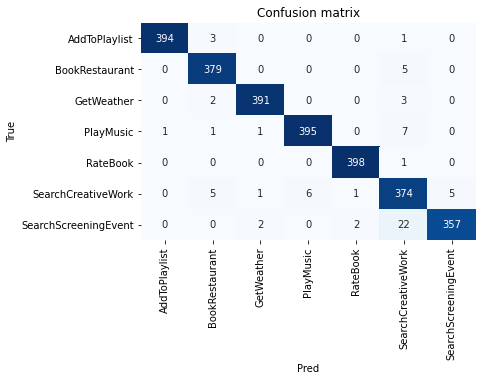

In [158]:
classes = np.unique(y_test)

print('Accuracy:', round(accuracy_score(y_test, predicted),2))
print('F1_score:', round(f1_score(y_test, predicted, average='weighted'),2))

print(classification_report(y_test, predicted))
# Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Wynik na poziomie 98% skuteczności i f1 na zbiorze testowym w danych treningowych uznaję za satysfakcjonujący.

Wyszukajmy jednak jeszcze możliwie najlepszych hiperparamterów modelu RandoForestClassifer za pomocą GridSearcha.

In [159]:
from sklearn.model_selection import GridSearchCV

In [160]:
# params_forest = {
#     # 'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 7, 15],
#     'min_samples_split': [2, 4, 6, 9],
#     # 'min_samples_leaf': [2, 3, 4, 5],
#     # 'max_features': ['auto', None]
# }
# clf = GridSearchCV(RandomForestClassifier(random_state=42), params_forest,scoring='f1_weighted',)
# clf.fit(X_train, y_train)
# clf.best_params_

Dofitujmy do danych najlepiej sparametryzowany model.

In [161]:
# zdefiniowanie najlepszego modelu
clf = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=2)

In [162]:
# pipeline
model = Pipeline([('vectorizer', vectorizer_tf_idf),
                  ('classifier', clf)])

# train classifier
model['classifier'].fit(X_train, y_train)

# test
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

i zobaczmy wyniki

Accuracy: 0.96
F1_score: 0.96
                      precision    recall  f1-score   support

       AddToPlaylist       0.99      0.99      0.99       398
      BookRestaurant       0.96      0.99      0.98       384
          GetWeather       0.95      0.99      0.97       396
           PlayMusic       0.96      0.98      0.97       405
            RateBook       0.99      1.00      0.99       399
  SearchCreativeWork       0.92      0.90      0.91       392
SearchScreeningEvent       0.97      0.90      0.93       383

            accuracy                           0.96      2757
           macro avg       0.96      0.96      0.96      2757
        weighted avg       0.96      0.96      0.96      2757



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

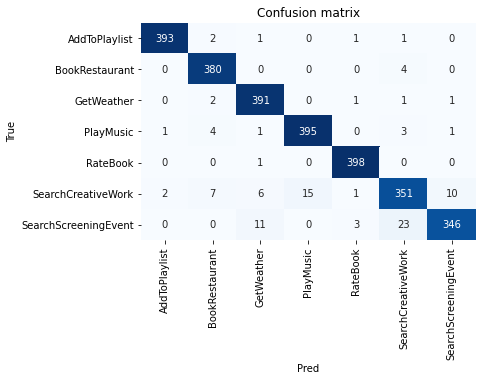

In [163]:
classes = np.unique(y_test)

print('Accuracy:', round(accuracy_score(y_test, predicted),2))
print('F1_score:', round(f1_score(y_test, predicted, average='weighted'),2))

print(classification_report(y_test, predicted))
# Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Jak widać z powyższych wyników, najlepsze wyniki uzyskujemy na domyślnych parametrach RandomForestClassifier.

Sprawdźmy, jak zachowa się model na danych walidacyjnych.

Przeprocesowaie danych walidacyjnych i dodanie nowej kolumny z oczyszczonym tekstem.

In [164]:
# dodanie nowej kolumny do istniejącego data_validation z oczyszczonymi komendami użytkowników
data_validation['text_clean'] = data_validation['text'].apply(lambda x:
                                                    utils_preprocess_text(
                                                        x,
                                                        flg_lemm=True,
                                                        lst_stopwords=set(stopwords.words('english'))
                                                    ))
data_validation.sample(5)

,text,label,text_clean
394,Give Joe Magarac and His USA Citizen Papers 5 ...,RateBook,Give Joe Magarac His USA Citizen Papers 5 point
564,Give one start to the current book,RateBook,Give one start current book
442,Add this artist to fairy tales playlist,AddToPlaylist,Add artist fairy tale playlist
46,Will it be colder in Virgin Islands National P...,GetWeather,Will colder Virgin Islands National Park
47,Play This Is: Miles Davis on Lastfm.,PlayMusic,Play This Is Miles Davis Lastfm


In [165]:
# wydzielenie X_val
X_val = data_validation['text_clean'].values

# wydzielenie y_val
y_val = data_validation['label'].values

In [166]:
# walidacja zbioru testowego

# pipeline
model = Pipeline([('vectorizer', vectorizer_tf_idf),
                  ('classifier', rfc)])

# train classifier
model['classifier'].fit(X_train, y_train)

# test
predicted_val = model.predict(X_val)
predicted_prob_val = model.predict_proba(X_val)

Accuracy: 0.98
F1_score: 0.98
                      precision    recall  f1-score   support

       AddToPlaylist       0.98      1.00      0.99       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       1.00      0.98      0.99       100
           PlayMusic       0.99      0.96      0.97       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.92      0.97      0.95       100
SearchScreeningEvent       0.97      0.94      0.95       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

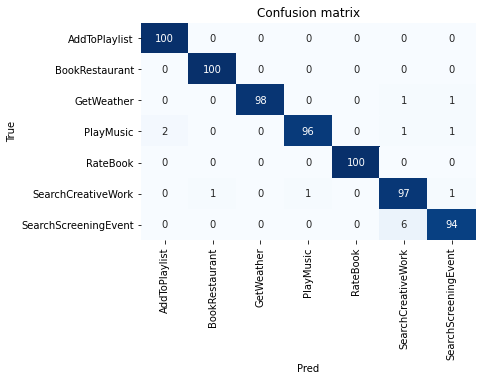

In [167]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, predicted_val),2))
print('F1_score:', round(f1_score(y_val, predicted_val, average='weighted'),2))

print(classification_report(y_val, predicted_val))
# Plot confusion matrix
cm = confusion_matrix(y_val, predicted_val)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Wyszukajmy przykładowe indeksy przypadków, w których model się pomylił i oceńmy sami, jakbyśmy zakfalifikowali daną komendę użytkownika.

In [168]:
indexes = []
for i, phrase in enumerate(predicted_val):
  if phrase == 'BookRestaurant':
    if y_val[i] == 'SearchCreativeWork':
      indexes.append(i)
print(indexes)

[426]


In [169]:
# Tekst komendy użytkownika

print(f'True category: {y_val[426]}')
print(f'Predicted category: {predicted_val[426]}')
print(f"----------------------------\nTekst komendy:\n{data_validation['text'][426]}")

True category: SearchCreativeWork
Predicted category: BookRestaurant
----------------------------
Tekst komendy:
Can you please get me the book Dracula 5: The Blood Legacy?


Sprawdźmy jeszcze jedne przypadek:

In [170]:
indexes = []
for i, phrase in enumerate(predicted_val):
  if phrase == 'PlayMusic':
    if y_val[i] == 'SearchCreativeWork':
      indexes.append(i)
print(indexes)

[288]


In [171]:
# Tekst komendy użytkownika

print(f'True category: {y_val[288]}')
print(f'Predicted category: {predicted_val[288]}')
print(f"----------------------------\nTekst komendy:\n{data_validation['text'][288]}")

True category: SearchCreativeWork
Predicted category: PlayMusic
----------------------------
Tekst komendy:
Am looking for a book with the title Free to Play


A Wy jakbyście zaklasyfikowali powyższe polecenia?

--------------------------------------------------------------------------------

Sprawdźmy jeszcze jak skuteczne będą dla tego zadania sieci rekurencyjne RNN.

# Tokenizer i sieci rekurencyjne RNN

In [172]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Do wyuczenia sieci będziemy musieli podać dane w postaci liczb. Na początek zmapujmy nasze 'labele' na liczby:

In [173]:
# Wyświeltnie unikalnych wartości labeli
np.unique(data_train['label'])

array(['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic',
       'RateBook', 'SearchCreativeWork', 'SearchScreeningEvent'],
      dtype=object)

In [174]:
# Mapowanie etykiet na liczby integer
y = data_train['label'].map({'AddToPlaylist': 1, 'BookRestaurant': 2, 'GetWeather': 3, 'PlayMusic': 4, 'RateBook': 5, 'SearchCreativeWork': 6, 'SearchScreeningEvent': 7}).values

In [175]:
# Wyświeltenie unkalnych wartości etykiet
np.unique(y)

array([1, 2, 3, 4, 5, 6, 7])

Zrzutowanie danych tekstowych do wektra słów.

In [176]:
X = data_train['text_clean'].values

Podzielmy raz jeszcze dane na treningowe i testowe w zbiorze treningowym.

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Utwórzmy tokenizer, aby przypisać indeksy do poszczególnych słów w zbiorze X_train.

In [178]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

Przekształćmy dane treningowe X_train i testowe X_test na wektory indeksów.

In [179]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [180]:
# Sprawdzenie przykładowego X_test
X_test[10]

[14, 78, 49, 19]

Sprawdźmy max i średnią długość komendy tekstowej w celu określenia ile tokenów warto rozważać, a ile pominąć.

In [181]:
size = []
for i, k in enumerate(X_train):
  size.append(len(k))
print(f'Max X_train size: {max(size)}')
print(f'AVG X_train_size: {round(np.mean(size), 2)}')

Max X_train size: 18
AVG X_train_size: 5.83


W związku z koniecznością zrównania długości inputowanych do sieci RNN tokenów przyjmiemy do dalszych rozważań 18 pierwszysch tokenów tj. w oparciu o najdłuższą komendę użytkowanika w zbiorze X_train. Mamy do dyspozycji GPU, więc taka ilość nie będzie kosztowna obliczeniowo.
W komendach, gdzie występuje mniej tokenów, rozmiar komendy zostanie dostosowany do długości 18 tokenów za pomocą paddingu.

In [182]:
# bierzemy 18 pierwszych tokenów
maxlen = 18
vocab_size = len(tokenizer.word_index) + 1 # dadajemy 1 na specjalne tokeny

X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=maxlen)

Wyświetlmy przykładową komendę użytkownika poddaną paddingowi:

In [183]:
X_train[18]

array([   1,   43, 3875,  816,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

Jak widać na powyższym przykładzie komenda składająca się pierwotnie z 4 słów ~ tokenów została rozszerzona do długości 18. Początek komendy został zachowany.

Przystąpmy do zbudowania sieci RNN.

In [184]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

Stwórzmy architekturę sieci rekurencyjnej z warstwą LSTM.

In [215]:
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=maxlen)) # wektory długości 300
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.3, return_sequences=False,kernel_initializer='he_uniform')))  # warstwa dwukierunkowa (złożona niejako z dwóch warstw; 
                                                                                                                                    # każda z dodatkowym dropoutem)
model.add(Dense(256, activation='relu'))  # dodatkowa warstwa Dense
model.add(Dense(maxlen, activation='softmax')) # ostatnia warstwa złożona z 7 kategorii
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 18, 300)           2950800   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_15 (Dense)             (None, 18)                4626      
Total params: 3,057,314
Trainable params: 3,057,314
Non-trainable params: 0
_________________________________________________________________
None


In [186]:
# Sprawdzenie rozmiaru zbiorów treningowego i testowego
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11027, 18), (11027,), (2757, 18), (2757,))

In [216]:
history_lstm = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2))

Epoch 1/10
138/138 [==============================] - 26s 159ms/step - loss: 1.6835 - accuracy: 0.4802 - val_loss: 0.0983 - val_accuracy: 0.9710
Epoch 2/10
138/138 [==============================] - 21s 155ms/step - loss: 0.0564 - accuracy: 0.9854 - val_loss: 0.0733 - val_accuracy: 0.9773
Epoch 3/10
138/138 [==============================] - 21s 155ms/step - loss: 0.0166 - accuracy: 0.9967 - val_loss: 0.0705 - val_accuracy: 0.9778
Epoch 4/10
138/138 [==============================] - 22s 157ms/step - loss: 0.0084 - accuracy: 0.9987 - val_loss: 0.0761 - val_accuracy: 0.9778
Epoch 5/10
138/138 [==============================] - 22s 156ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0815 - val_accuracy: 0.9782
Epoch 00005: early stopping


Zwizualizujmy uczenie sieci za pomocą funkcji.

In [188]:
import plotly.graph_objects as go

# wykres pokazujący  dokładność i funkcje starty
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()
 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

In [189]:
plot_hist(history_lstm)

In [190]:
scores = model.evaluate(X_test, y_test)
print(f'Accuracy {scores[1]*100}%')

87/87 [==============================] - 1s 10ms/step - loss: 0.0926 - accuracy: 0.9775
Accuracy 97.75117635726929%


Jak widać z powyższych iteracji, wykresów i wyniku accuracy na zbiorze testowym w danych treningowych, sieć bardzo dobrze wyuczyła się właściwie klasyfikować komendy użytkowników i nie ma skłonności do overfittingu. Zanim sprawdzimy rezultaty na danych walidacyjnych, sprawdźmy wyniki dla zbioru testowego w classification report i confusion matrix.

In [191]:
predicted_lstm = np.argmax(model.predict(X_test), axis=-1)

In [192]:
# Wyświetlenie y_test
print(y_test)

[4 3 6 ... 4 4 6]


In [193]:
# Wyświetlenie y_test predict_lstm
print(predicted_lstm)

[4 3 6 ... 4 4 6]


In [194]:
# Odmapowanie etykiet z liczb integer na labele
y_test = pd.Series(y_test).map({1: 'AddToPlaylist', 2: 'BookRestaurant', 3: 'GetWeather', 4: 'PlayMusic', 5: 'RateBook', 6: 'SearchCreativeWork', 7: 'SearchScreeningEvent'})
predicted_lstm = pd.Series(predicted_lstm).map({1: 'AddToPlaylist', 2: 'BookRestaurant', 3: 'GetWeather', 4: 'PlayMusic', 5: 'RateBook', 6: 'SearchCreativeWork', 7: 'SearchScreeningEvent'}).values

In [195]:
# Wyświetlenie odmapowanego y_test
print(y_test)

0                  PlayMusic
1                 GetWeather
2         SearchCreativeWork
3       SearchScreeningEvent
4             BookRestaurant
                ...         
2752          BookRestaurant
2753    SearchScreeningEvent
2754               PlayMusic
2755               PlayMusic
2756      SearchCreativeWork
Length: 2757, dtype: object


Accuracy: 0.98
F1_score: 0.98
                      precision    recall  f1-score   support

       AddToPlaylist       1.00      0.99      1.00       398
      BookRestaurant       0.99      0.98      0.99       384
          GetWeather       0.99      0.99      0.99       396
           PlayMusic       0.99      0.95      0.97       405
            RateBook       1.00      1.00      1.00       399
  SearchCreativeWork       0.89      0.98      0.93       392
SearchScreeningEvent       0.99      0.95      0.97       383

            accuracy                           0.98      2757
           macro avg       0.98      0.98      0.98      2757
        weighted avg       0.98      0.98      0.98      2757



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

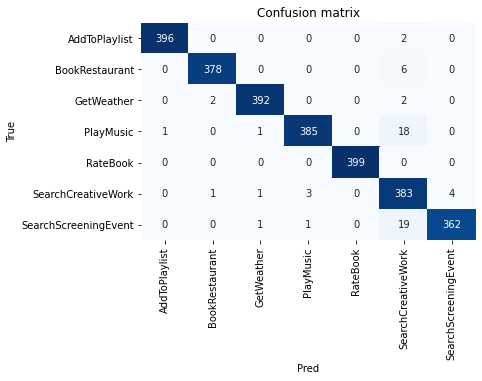

In [196]:
classes = np.unique(y_test)

print('Accuracy:', round(accuracy_score(y_test, predicted_lstm),2))
print('F1_score:', round(f1_score(y_test, predicted_lstm, average='weighted'),2))

print(classification_report(y_test, predicted_lstm))
# Plot confusion matrix
cm = confusion_matrix(y_test, predicted_lstm)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Jak widać powyżej, rezultaty uzysknaę za pomocą sieci LSTM na zbiorze testowym są bardzo zbliżone do tych uzyskanych kalsycznym klasyfiaktorem.

Sprawdźmy, jak to wygląda na zbiorze walidacyjnym. Przygotujemy w pierwszej kolejności dane, aby móc podać je sieci LSTM.

In [197]:
# wydzielenie X_val
X_val = data_validation['text_clean'].values

# wydzielenie y_val po zmapowaniu
y_val = data_validation['label'].map({'AddToPlaylist': 1, 'BookRestaurant': 2, 'GetWeather': 3, 'PlayMusic': 4, 'RateBook': 5, 'SearchCreativeWork': 6, 'SearchScreeningEvent': 7}).values

In [198]:
# tokenizacja i zamiana na słów na wektor indeksów
X_val = tokenizer.texts_to_sequences(X_val)

In [199]:
 # określeneie długości inputu danych walidacyjnych do sieci klasyfikującej
 X_val = pad_sequences(X_val, padding='post', truncating='post', maxlen=maxlen)

In [200]:
# wyświetlenie przygotowanych danych do "predykcji"
X_val

array([[  8,   3,  77, ...,   0,   0,   0],
       [202, 156,   1, ...,   0,   0,   0],
       [  8, 264,  21, ...,   0,   0,   0],
       ...,
       [ 14,  62,  40, ...,   0,   0,   0],
       [  8,  11,  21, ...,   0,   0,   0],
       [ 29,  25,  49, ...,   0,   0,   0]], dtype=int32)

Wykonajmy predykcję na wyuczonym już modelu sieci LSTM.

In [201]:
predicted_lstm_val = np.argmax(model.predict(X_val), axis=-1)

In [202]:
# Odmapowanie etykiet z liczb integer na labele
y_val = pd.Series(y_val).map({1: 'AddToPlaylist', 2: 'BookRestaurant', 3: 'GetWeather', 4: 'PlayMusic', 5: 'RateBook', 6: 'SearchCreativeWork', 7: 'SearchScreeningEvent'})
predicted_lstm_val = pd.Series(predicted_lstm_val).map({1: 'AddToPlaylist', 2: 'BookRestaurant', 3: 'GetWeather', 4: 'PlayMusic', 5: 'RateBook', 6: 'SearchCreativeWork', 7: 'SearchScreeningEvent'}).values

Accuracy: 0.98
F1_score: 0.98
                      precision    recall  f1-score   support

       AddToPlaylist       0.98      1.00      0.99       100
      BookRestaurant       1.00      0.99      0.99       100
          GetWeather       0.98      0.98      0.98       100
           PlayMusic       1.00      0.96      0.98       100
            RateBook       1.00      0.99      0.99       100
  SearchCreativeWork       0.91      0.98      0.94       100
SearchScreeningEvent       0.98      0.94      0.96       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

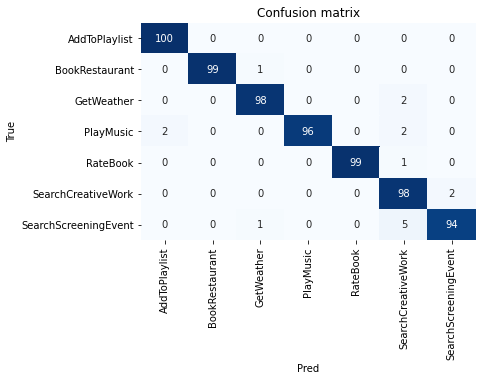

In [203]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, predicted_lstm_val),2))
print('F1_score:', round(f1_score(y_val, predicted_lstm_val, average='weighted'),2))

print(classification_report(y_val, predicted_lstm_val))
# Plot confusion matrix
cm = confusion_matrix(y_val, predicted_lstm_val)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Jak widać na powyższych rezultatach, wyniki otrzymane dzięki sieci RNN z warstwą LSTM są bardzo zbliżone na zbiorze walidacyjnym do tych uzyskanych klasycznym klasyfiaktorem. Pomimo, że ogóle accuracy czy f1_score są zbliżone, to sieć myli się często w innych przypadkach niż mylił się klasyczny klasyfikator.

Sprawdźmy i oceńmy sami komendę, którą sieć zaklasyfikowała niepoprawnie.

In [204]:
indexes = []
for i, phrase in enumerate(predicted_lstm_val):
  if phrase == 'GetWeather':
    if y_val[i] == 'BookRestaurant':
      indexes.append(i)
print(indexes)

[378]


In [205]:
# Tekst komendy użytkownika

print(f'True category: {y_val[378]}')
print(f'Predicted category: {predicted_lstm_val[378]}')
print(f"----------------------------\nTekst komendy:\n{data_validation['text'][378]}")

True category: BookRestaurant
Predicted category: GetWeather
----------------------------
Tekst komendy:
I want to book Oregon Electric Station in North City.


# Wnioski

Detektor intencji, który udało się zbudować w niniejszym notatniku bazując na modelu klasycznego klasyfikatora RandomForest i sieci rekurencyjnej z warstwą LSTM pokazuje, że niezależnie czy opiera się on na sieci czy na klasyfikatorze, uzyskuje bardzo dobre wyniki na poziomie 98% accuracy i 94% - 95% f1_score, co pozwala uznać go za użyteczny. 

Ciekawostką jest, że sieć i klasyfikator pomimo zbliżonych ogólnych rezultatów, myliły się często w innych przypadkach, co wskazuje na różne mechanizmy klasyfikownia danych, aczkolwiek równie skuteczne.